In [1]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold,cross_val_score
from sklearn.metrics import mean_squared_error

from itertools import combinations,chain

In [2]:
import numpy as np
import pandas as pd

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

%matplotlib inline

The standard linear model $Y=\beta_0+\beta_1X_1+...+\beta_pX_p+\epsilon$ is used to describe the relationship between response $Y$ and a set of variables $X_1,...,X_p$. Usually, the model is fitted using least square method. However, it is possible to use other fitting procedures that can yeild prediction accuracy and model interpritability.

* **Prediction Accuracy:** If the true relationship between the response and the predictor is approximately linear, the least square estimates will have low bias. If the number of predictors ($p$) is much less than the number of observations ($n$) then the least square estimates tend to also have low variance, and will perform well on test observations. However, if $n$ is not much larger than p, then there can be a lot of variability in the least square fit.
* **Model Interpretability:** Many of the variables used in a multiple regression model may not be associated with the response. By removing these variables we can obtain a model that is easily interpreted.

#### Performing Subset Selection for Credit data set

In [4]:
credit = pd.read_csv('./Credit.csv')
credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 12 columns):
Unnamed: 0    400 non-null int64
Income        400 non-null float64
Limit         400 non-null int64
Rating        400 non-null int64
Cards         400 non-null int64
Age           400 non-null int64
Education     400 non-null int64
Gender        400 non-null object
Student       400 non-null object
Married       400 non-null object
Ethnicity     400 non-null object
Balance       400 non-null int64
dtypes: float64(1), int64(7), object(4)
memory usage: 37.6+ KB


In [5]:
# Creating dummy variables for categorical data. For variables with two levels we can use pd.factorize()
credit['d_Gender']=pd.factorize(credit['Gender'])[0]
print ('d_Gender factors',pd.factorize(credit['Gender'])[1])

credit['d_Student']=pd.factorize(credit['Student'])[0]
print ('d_Gender factors',pd.factorize(credit['Student'])[1])

credit['d_Married']=pd.factorize(credit['Married'])[0]
print ('d_Gender factors',pd.factorize(credit['Married'])[1])

credit = pd.concat([credit,pd.get_dummies(credit['Ethnicity'],prefix='D')],axis=1)

d_Gender factors Index([' Male', 'Female'], dtype='object')
d_Gender factors Index(['No', 'Yes'], dtype='object')
d_Gender factors Index(['Yes', 'No'], dtype='object')


In [6]:
credit.columns

Index(['Unnamed: 0', 'Income', 'Limit', 'Rating', 'Cards', 'Age', 'Education',
       'Gender', 'Student', 'Married', 'Ethnicity', 'Balance', 'd_Gender',
       'd_Student', 'd_Married', 'D_African American', 'D_Asian',
       'D_Caucasian'],
      dtype='object')

In [90]:
features = ['Income', 'Limit', 'Rating', 'Cards', 'Age', 'Education', 'd_Gender',
            'd_Student', 'd_Married', 'D_African American', 'D_Asian']
target = ['Balance']

### Subset Selection  
The best subset model selection approach identifies a subset of the predictors that show to be related to the response. We can then fit a model on the reduced set of variables.

#### Best Subset Selection
To perform best subset selection, we perform a seperate least square regression for all possible combination of $p$ predictors, resulting in $2^p$ possible models, with the goal of identifying the one that is best.

This is usually broken up into three stages.
1. Let $M_0$ denote the null model, which contains no predictors. This model simple predicts the sample mean for each observation.
2. For $k=1,2,..p$:  
    a. Fit all $(^p_k)$ models that contain exactly k predcitors.  
    b. Pick best amoung these models, and call it $M_k$. Here the best is defined as having the smallest RSS, or equivalently largest $R^2$
3. Select a single best model from among $M_0,...,M_p$ using cross validation prediction error, $C_p (AIC), BIC$ or adjusted $R^2$

In [158]:
# Create list of all possible subsets for the predictors
p_subsets = list(chain.from_iterable(combinations(features,k) for k in range(1,12)))
regr = LinearRegression()

# Create empty list to record the training scores of each model
sub_model_score = []

# For each of the subsets fit a linear regression model and record it's training score
for subset in p_subsets:
    X = credit[list(subset)]
    y = credit[target]
    
    sub_model = regr.fit(X,y)
    sub_model_score.append(sub_model.score(X,y))

In [160]:
def best_model(p_subsets, sub_model_score):
    # record the best training score for each of the model sizes
    sub_scores = {}
    #  record the best subset for each of the model sizes
    subsets = {}

    for i, subset in enumerate(p_subsets):
        if sub_scores.get(len(subset),-np.Infinity) < sub_model_score[i]:
            sub_scores[len(subset)] =   sub_model_score[i]
            subsets[len(subset)] = subset   
    return sub_scores, subsets

best_sub_scores, best_subset = best_model(p_subsets, sub_model_score)

If we look at the best subset scores for each model size we can see the $R^2$ increasing as more predictors are added to the model. However, these indicates the training errors whereas we wish to choose a model that has the lowest test error. Therefore, we use cross validation prediction on the best model for each model size.

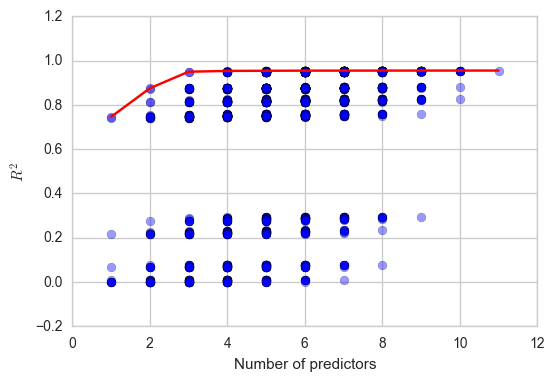

In [153]:
plt.scatter([len(p) for p in p_subsets], sub_model_score, alpha = 0.4, s = 40)
plt.xlabel('Number of predictors')
plt.ylabel(r'$R^2$')
model_size, best_model_score = zip(*sorted(best_sub_scores.items()))
plt.plot(model_size,best_model_score,c = 'r')

As the number of predictors increase the model fit improves as well, however from three-variable model on, there is little improvement in RSS and $R^2$ as a result of including additional predictors.
While the best subset selection in simple and conceptually simple, it has computational limitations. When considering a dataset with $p$ predictors there are $2^p$ possible model with needs to be evaluated to identify the best subset. Consequently, best subset selection becomes computationally infeasible for values of $p$ greater than around 20.

#### Stepwise Selection
We cannot use the best subset selection to datasets where the number of predictors is very large.Also as the search space increase there is a possiblity that we will select models that perform well in the training data but may not perform will with test data.Althernativly, we can use stepwise methods, which explore a far less resticted set of model.

In [154]:
predictors = features[:]
p_subsets = []
sub_model_scores =[]
Kth_variable = []

for i in range(len(features)):
    Kplus_score = -np.Infinity
    for predictor in predictors:
        if predictor not in Kth_variable:
            X = credit[Kth_variable+[predictor]]
            y = credit[target]
            
            p_subsets.append(Kth_variable+[predictor])
            model = regr.fit(X,y)
            
            sub_model_scores.append(regr.score(X,y))
            if regr.score(X,y) > Kplus_score:
                Kplus_score = model.score(X,y)
                Kpluse_predictor = predictor
    Kth_variable.append(Kpluse_predictor)

In [161]:
best_sub_scores, best_subset = best_model(p_subsets, sub_model_score)

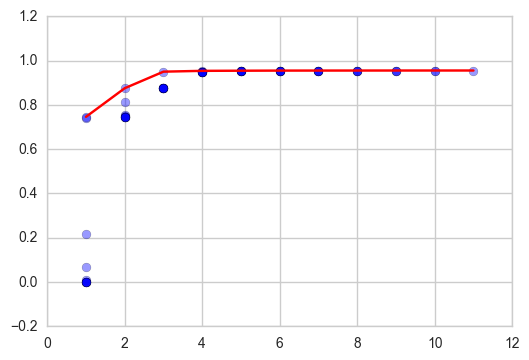

In [162]:
plt.scatter(list(map(len,sub_models)), sub_model_scores, alpha= 0.4, s =40)

model_size, best_model_score = zip(*sorted(best_sub_scores.items()))
plt.plot(model_size,best_model_score,c = 'r')

In [143]:
list(map(len,sub_models))

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 6,
 6,
 6,
 6,
 6,
 6,
 7,
 7,
 7,
 7,
 7,
 8,
 8,
 8,
 8,
 9,
 9,
 9,
 10,
 10,
 11]

In [120]:
for predictor in features:
    print (credit[K+[predictor]].head())

    Income  Limit  Rating  Cards   Income
0   14.891   3606     283      2   14.891
1  106.025   6645     483      3  106.025
2  104.593   7075     514      4  104.593
3  148.924   9504     681      3  148.924
4   55.882   4897     357      2   55.882
    Income  Limit  Rating  Cards  Limit
0   14.891   3606     283      2   3606
1  106.025   6645     483      3   6645
2  104.593   7075     514      4   7075
3  148.924   9504     681      3   9504
4   55.882   4897     357      2   4897
    Income  Limit  Rating  Cards  Rating
0   14.891   3606     283      2     283
1  106.025   6645     483      3     483
2  104.593   7075     514      4     514
3  148.924   9504     681      3     681
4   55.882   4897     357      2     357
    Income  Limit  Rating  Cards  Cards
0   14.891   3606     283      2      2
1  106.025   6645     483      3      3
2  104.593   7075     514      4      4
3  148.924   9504     681      3      3
4   55.882   4897     357      2      2
    Income  Limit  Rat

In [103]:
K = ['Income', 'Limit', 'Rating', 'Cards']

In [ ]:
x

In [ ]:
import statsmodels.api as sm

In [ ]:
model=sm.OLS(credit['Balance'],credit[features],hasconst=False).fit()

In [ ]:
model.summary()

In [ ]:
model.summary()

In [ ]:
regr = LinearRegression()

In [ ]:
X = credit[['Limit', 'Rating', 'Cards', 'Age']]
y = credit[target]

In [ ]:
model = regr.fit(X,y)

In [ ]:
model.score(X,y)